In [1]:
import os
import sys

# add parent folder to path if needed
parent_dir = os.getcwd().replace('\\notebooks', '')
if parent_dir not in sys.path:
    sys.path = [parent_dir] + sys.path

import numpy as np
import pandas as pd
import tensorflow as tf
from src import restaurants
from src.restaurants import models
from src.util.preprocessing import Scaler

np.random.seed(0)
tf.random.set_seed(0)

# Dataset for Ranking Restaurants

> Note: this notebook is derived from [Shape Constraints with Tensorflow Lattice](https://www.tensorflow.org/lattice/tutorials/shape_constraints) and should be considered as an extension of it.

Imagine a simplified scenario where we want to determine whether users will click on a restaurant search result.

The task is to predict the click-through rate (*CTR*) given input features:
- average rating (`avg_rating`): a numeric feature with values in the range [1,5].
- number of reviews (`num_reviews`): a numeric feature with values capped at 200, which we use as a measure of trendiness.
- dollar rating (`dollar_rating`): a categorical feature with string values in the set {"D", "DD", "DDD", "DDDD"}.

The dataset had been created synthetically from the *CTR* formula:
$$
CTR = \frac{1}{1 + e^x}, \ \mbox{where} \ x=b(\mbox{dollar_rating}) - \frac{\mbox{avg_rating} \times log(\mbox{num_reviews})}{4}
$$
where $b(\cdot)$ translates each `dollar_rating` to a baseline value:
$$\mbox{D}\to 3,\ \mbox{DD}\to 2,\ \mbox{DDD}\to 4,\ \mbox{DDDD}\to 4.5 $$

This formula reflects typical user patterns. e.g. given everything else fixed, users prefer restaurants with higher star ratings, and "\\$\\$" restaurants will receive more clicks than "\\$", followed by "\\$\\$\\$" and "\\$\\$\\$\\$". 

Moreover, when the train, validation, and test set are generated, it is taken into account that users will likely only see restaurants already considered "good" by the current ranking model in use. As a result, "good" restaurants are more frequently impressed and over-represented in the training datasets.

The data consist in the three attributes used for prediction plus a binary label representing whether a user has clicked on the advertisement for that specific restaurant or not. To be noted that, as different users may or may not decide to click, different data points regarding the same restaurant could have different labels.

In [2]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = restaurants.load_data()
scaler = Scaler(x_train, methods=dict(avg_rating='std', num_reviews='std'))

print(len(x_train), 'train samples', end=', ')
print(len(x_val), 'val samples', end=', ')
print(len(x_test), 'test samples')
x_train.join(y_train)

413 train samples, 181 val samples, 1791 test samples


,avg_rating,num_reviews,D,DD,DDD,DDDD,clicked
0,3.583576,106,1,0,0,0,1
1,2.533766,156,1,0,0,0,1
2,2.533766,156,1,0,0,0,1
3,4.166900,22,1,0,0,0,0
4,4.166900,22,1,0,0,0,1
...,...,...,...,...,...,...,...
408,4.689194,48,1,0,0,0,1
409,4.689194,48,1,0,0,0,1
410,4.084902,118,1,0,0,0,1
411,4.084902,118,1,0,0,0,1


The training dataset mostly consists of user interactions with good and popular restaurants, while the testing dataset has a uniform distribution to simulate the evaluation setting discussed above.

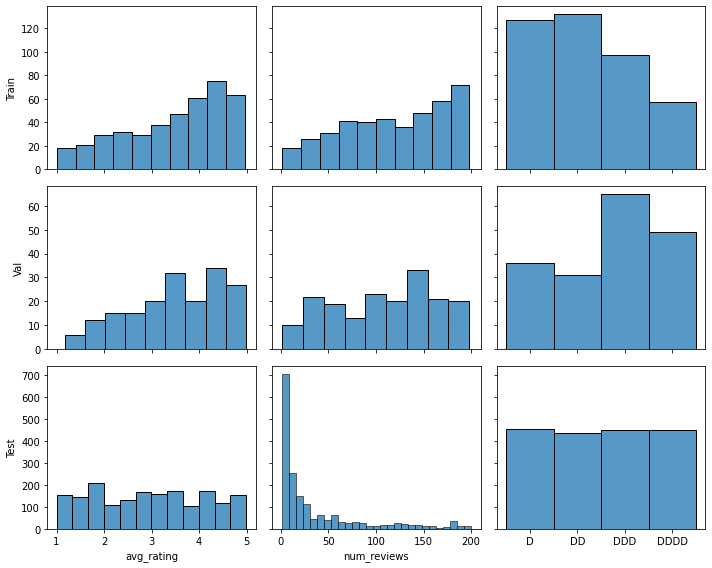

In [3]:
restaurants.plot_histograms(train=x_train, val=x_val, test=x_test)

Here, we plot as well the distribution of the data depending on the `clicked` attribute in each dataset split.

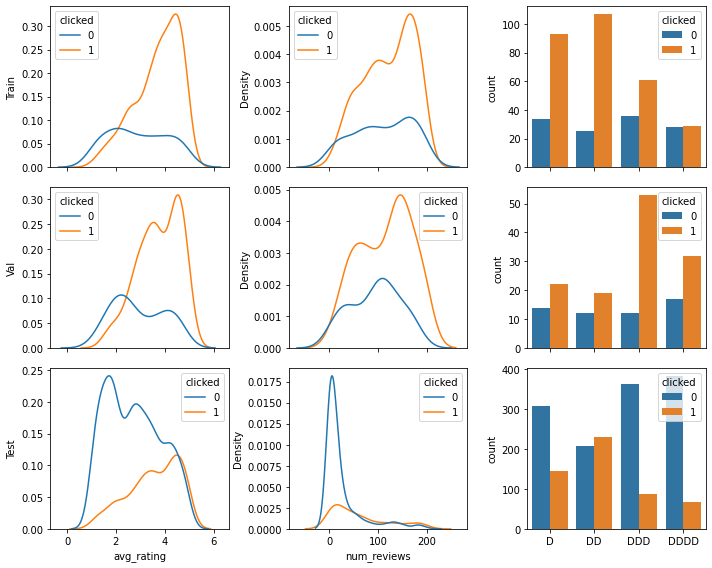

In [4]:
restaurants.plot_distributions(train=(x_train, y_train), val=(x_val, y_val), test=(x_test, y_test))

# Baseline Multi-Layer Perceptron

As a baseline, we develop a *MLP* architecture with *ReLU* activation function, and a final *sigmoid*-activated linear layer to predict the `clicked` attribute. Using the custom *MLPBatchGenerator*, the numeric features are standardized, and the categorical feature is one-hot encoded, leading to an input vector with six features.

We use the *Adam* optimizer and *binary crossentropy* loss to guide the backpropagation; moreover, we use the *EarlyStopping* callback to monitor the validation loss in order to stop the training whenever the model seems to start overfitting.

Given that this is not a classification problem, the accuracy is not a good metric:
* the output of our system is indeed meant to be interpreted as a probability
* we will make an evaluation based on the *ROC* curve and, in particular, using the Area Under Curve (*AUC*) metric

Finally, as the dataset is synthetic, we know the exact distribution of the *CTR*, and we will be able to compare it with the distribution learned from the model.

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

mlp = models.MLPClassifier(hidden=[16, 8, 8], scaler=scaler)
mlp.compile(optimizer='adam', loss='binary_crossentropy')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
mlp.fit(x_train, y_train, epochs=200, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/200
13/13 [==============================] - 1s 25ms/step - loss: 0.7060 - val_loss: 0.6886
Epoch 2/200
13/13 [==============================] - 0s 4ms/step - loss: 0.6826 - val_loss: 0.6710
Epoch 3/200
13/13 [==============================] - 0s 4ms/step - loss: 0.6624 - val_loss: 0.6546
Epoch 4/200
13/13 [==============================] - 0s 4ms/step - loss: 0.6512 - val_loss: 0.6403
Epoch 5/200
13/13 [==============================] - 0s 4ms/step - loss: 0.6336 - val_loss: 0.6236
Epoch 6/200
13/13 [==============================] - 0s 3ms/step - loss: 0.6146 - val_loss: 0.6061
Epoch 7/200
13/13 [==============================] - 0s 4ms/step - loss: 0.6112 - val_loss: 0.5901
Epoch 8/200
13/13 [==============================] - 0s 3ms/step - loss: 0.6009 - val_loss: 0.5772
Epoch 9/200
13/13 [==============================] - 0s 4ms/step - loss: 0.6070 - val_loss: 0.5663
Epoch 10/200
13/13 [==============================] - 0s 4ms/step - loss: 0.5730 - val_loss: 0.5550
Epoch 11

The distributions learned by the model are clearly do not satisfy the monotonicities which we expect, namely:
* the *CTR* increases together with the average rating
* the *CTR* increases together with the number of reviews
* the *CTR* for "\\$\\$" should be greater than that for "\\$" and "\\$\\$\\$\\$"

0.8417017101205495 (train auc), 0.7940115440115438 (val auc), 0.8299388026872951 (test auc)


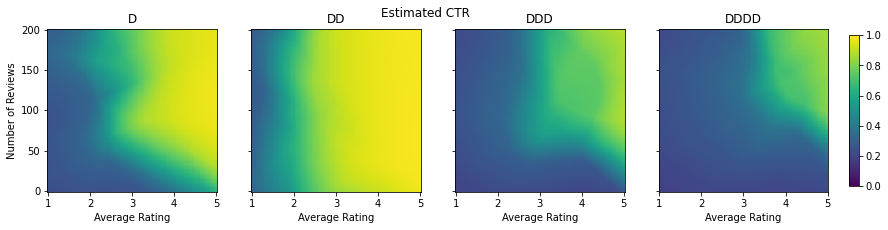

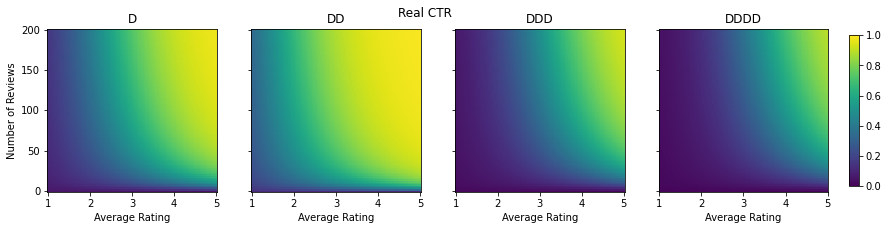

In [6]:
mlp.evaluation_summary(train=(x_train, y_train), val=(x_val, y_val), test=(x_test, y_test))

# Semantic-Based Regularized MLP

To overcome the issues of the baseline *MLP* we extended the same architecture with a semantic-based regularizer in order to inject some knowledge about the monotonicities. However, as the monotonicities can be forced only on pairs of samples that share each attribute except for one, we need to augment our initial data so to create fake samples to be used in an unsupervised manner by the regularizer that will penalize those samples that do not respect the monotonicity using the loss function:
$$
\mathscr{L}_{regularizer}(x_1, x_2) = max(0, - monotonicity \times activation(delta)), \ \mbox{where} \ delta = \mbox{ctr}(x_1) - \mbox{ctr}(x_2)
$$
where $monotonicity \in [-1, 0, 1]$ depending on the input features, and the $activation$ function is a custom function that can be chosen by the user.

The total loss $\mathscr{L}$ is then computed as:
$$
\mathscr{L} = \mathscr{L}_{supervised} + \alpha \cdot \mathscr{L}_{regularizer}
$$
where $\alpha$ is a dynamic variable which is optimized by the model itself using the *Lagrangian Dual* technique. Note that $\mathscr{L}_{supervised}$ is computed on the original samples only, because the augmented samples do not have a label, therefore if $\alpha = 0$ the behaviour is the same one of the baseline *MLP*.

A known burden of this kind of approach is that samples that should be confronted to compute the regularizer loss must be in the same batch. This is problematic in two ways:
1. we need to take care of the batch generation so that each augmented sample is in the same batch of its corresponding original sample, and that the position of the original samples is known
2. the stochastic gradient descent has been proven to perform better when the data of a single batch has a distribution which is similar to that of the entire dataset, an assumption that is clearly broken in this context

## Augmented Data for the Regularizer

The augmented dataset is generated in this way:
* for each example $x$ in the original dataset:
    * for each monotonic attribute $a$:
        * we sample a new value for the attribute $a$, say $x'_{a}$, using a uniform sampling technique
        * we generate a new example $x' = (x'_{a}, x_{\neg a})$ which is identical to $x$ in each attribute except $a$
        * we compute the expected monotonicity $m \in [-1, 0, 1]$ for $x'$ with respect to $x$

We generate 5 samples for each of the three monotonic attributes, for a total of 15 augmented sample plus the original one.

In [7]:
x_aug = restaurants.augment_data(x_train, n=5)
x_aug_train = pd.concat((x_train.reset_index(), x_aug))
x_aug_train = x_aug_train.replace(np.nan, 0.).reset_index(drop=True)
y_aug_train = y_train.append(pd.Series([-1] * len(x_aug), name='clicked'), ignore_index=True)
x_aug.join(x_train, on='index', lsuffix='_aug')

,index,avg_rating_aug,num_reviews_aug,D_aug,DD_aug,DDD_aug,DDDD_aug,monotonicity,avg_rating,num_reviews,D,DD,DDD,DDDD
0,0,1.925673,106,1,0,0,0,-1,3.583576,106,1,0,0,0
1,0,2.908442,106,1,0,0,0,-1,3.583576,106,1,0,0,0
2,0,1.299353,106,1,0,0,0,-1,3.583576,106,1,0,0,0
3,0,4.592287,106,1,0,0,0,1,3.583576,106,1,0,0,0
4,0,2.632895,106,1,0,0,0,-1,3.583576,106,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6190,412,3.059689,46,0,0,1,0,0,3.059689,46,0,1,0,0
6191,412,3.059689,46,0,0,0,1,-1,3.059689,46,0,1,0,0
6192,412,3.059689,46,0,1,0,0,0,3.059689,46,0,1,0,0
6193,412,3.059689,46,0,0,1,0,0,3.059689,46,0,1,0,0


Histograms for the train, test, and augmented train data, respectively.

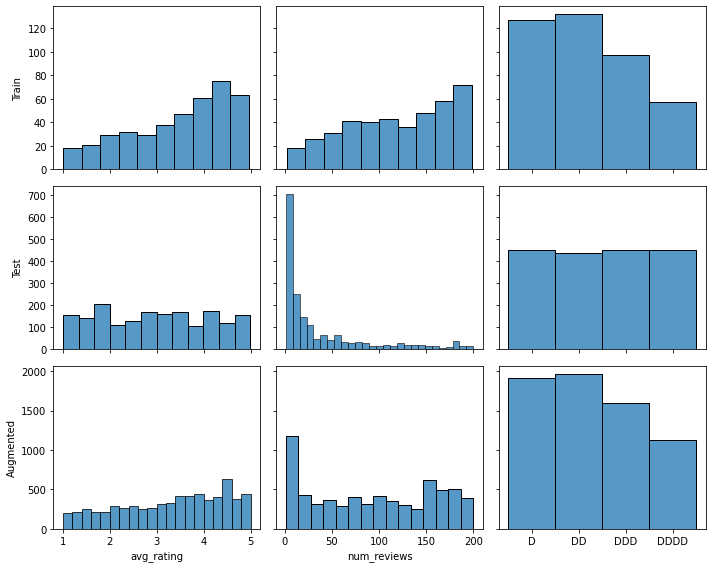

In [8]:
restaurants.plot_histograms(train=x_train, test=x_test, augmented=x_aug_train)

Distributions of the train, test, and augmented train data, respectively.
* the label -1 stands for the augmented samples, which are unsupervised

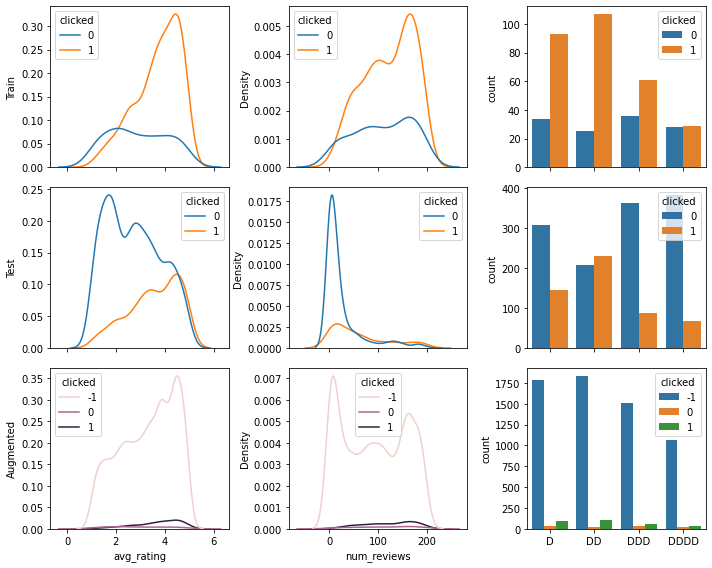

In [9]:
restaurants.plot_distributions(train=(x_train, y_train), test=(x_test, y_test), augmented=(x_aug_train, y_aug_train))

Finally, we use a custom batch generator to let all the augmented samples be in the same batch of the corresponding original one (in particular, the original sample is always followed by the other 15 augmented ones, so that during the train step it will be easier to compare each *CTR* of an augmented sample with that of the original one).

In [10]:
sbr_batches = models.SBRBatchGenerator(x_aug_train, y_aug_train, 4)
sbr_batches.batches[0].iloc[:16]

,avg_rating,num_reviews,D,DD,DDD,DDDD,monotonicity,clicked
0,3.583576,106,1,0,0,0,0.0,1
1,1.925673,106,1,0,0,0,-1.0,-1
2,2.908442,106,1,0,0,0,-1.0,-1
3,1.299353,106,1,0,0,0,-1.0,-1
4,4.592287,106,1,0,0,0,1.0,-1
5,2.632895,106,1,0,0,0,-1.0,-1
6,3.583576,7,1,0,0,0,-1.0,-1
7,3.583576,11,1,0,0,0,-1.0,-1
8,3.583576,133,1,0,0,0,1.0,-1
9,3.583576,125,1,0,0,0,1.0,-1


## Regularizer with No Activation Function

In this first experiment, we use no activation function, therefore the regularizer loss is:

$$
\mathscr{L}_{regularizer}(x_1, x_2) = max(0, - monotonicity \times delta)
$$

The other settings (i.e., the layers, the optimizer, the loss function, and the callbacks) are the equal to those of the baseline *MLP*.

As expected, this loss creates a known issue regarding semantic-based regularizers, i.e., the predictions are flattened  towards an average value because the model tends to satisfy the monotonicity constraint by predicting almost the same value independently of the input features.

In [11]:
sbr_none = models.SBRClassifier(num_augmented_samples=16, hidden=[16, 8, 8], scaler=scaler)
sbr_none.compile(optimizer='adam', loss='binary_crossentropy')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
sbr_none.fit(sbr_batches, epochs=200, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/200
104/104 [==============================] - 1s 4ms/step - alpha: 0.0354 - tot_loss: 0.8481 - def_loss: 0.6880 - reg_loss: 7.0582 - val_loss: 0.6803
Epoch 2/200
104/104 [==============================] - 0s 3ms/step - alpha: 0.0673 - tot_loss: 0.7687 - def_loss: 0.6749 - reg_loss: 1.4276 - val_loss: 0.6707
Epoch 3/200
104/104 [==============================] - 0s 3ms/step - alpha: 0.0828 - tot_loss: 0.7076 - def_loss: 0.6644 - reg_loss: 0.5304 - val_loss: 0.6613
Epoch 4/200
104/104 [==============================] - 0s 3ms/step - alpha: 0.0903 - tot_loss: 0.6835 - def_loss: 0.6553 - reg_loss: 0.3120 - val_loss: 0.6533
Epoch 5/200
104/104 [==============================] - 0s 3ms/step - alpha: 0.0964 - tot_loss: 0.6638 - def_loss: 0.6475 - reg_loss: 0.1694 - val_loss: 0.6472
Epoch 6/200
104/104 [==============================] - 0s 3ms/step - alpha: 0.1002 - tot_loss: 0.6499 - def_loss: 0.6411 - reg_loss: 0.0878 - val_loss: 0.6414
Epoch 7/200
104/104 [=========================

The issue is made clear not only by the fact that the *AUC* scores are lower that those of the baseline, but more importantly that the estimated *CTR* exhibits a single patch of color.

0.5 (train auc), 0.5 (val auc), 0.49679424835036595 (test auc)


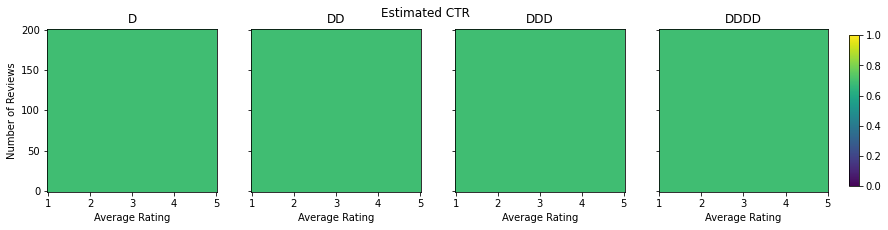

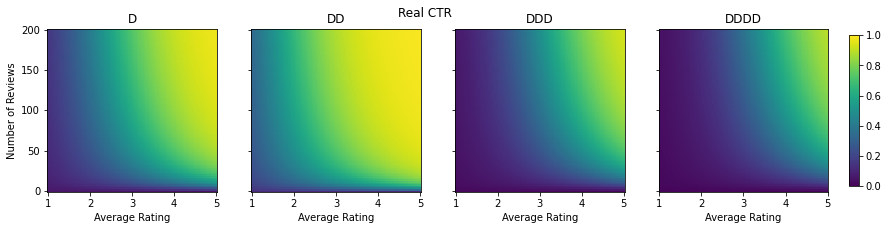

In [12]:
sbr_none.evaluation_summary(train=(x_train, y_train), val=(x_val, y_val), test=(x_test, y_test))

## Regularizer with Hard-Tanh Activation

To overcome the problems of the *SBR* model with no activation function, we now use an *hard-tanh* activation, which behaves very similarly to an *indicator*/*sign* function, leading to a loss:
$$
\mathscr{L}_{regularizer}(x_1, x_2) = max(0, - monotonicity \times tanh(10^6 \cdot delta))
$$

The idea is to penalize in the same way each kind of violation, whether it is a strong or a weak one. In this way, the model is forced to create an explicit ordering because even the smallest violation of the constraint will result in a huge loss.

In [13]:
import tensorflow.keras.backend as k
 
def activation(x):
    return k.tanh(10e6 * x)

sbr_tanh = models.SBRClassifier(num_augmented_samples=16, hidden=[16, 8, 8], scaler=scaler, reg_activation=activation)
sbr_tanh.compile(optimizer='adam', loss='binary_crossentropy')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
sbr_tanh.fit(sbr_batches, epochs=200, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/200
104/104 [==============================] - ETA: 0s - alpha: 0.0493 - tot_loss: 61.9382 - def_loss: 0.6656 - reg_loss: 1301.9500 - 1s 4ms/step - alpha: 0.0512 - tot_loss: 64.4238 - def_loss: 0.6651 - reg_loss: 1301.2885 - val_loss: 0.6434
Epoch 2/200
104/104 [==============================] - 0s 4ms/step - alpha: 0.1510 - tot_loss: 190.6418 - def_loss: 0.6316 - reg_loss: 1269.7404 - val_loss: 0.6108
Epoch 3/200
104/104 [==============================] - 0s 3ms/step - alpha: 0.2484 - tot_loss: 277.3393 - def_loss: 0.5977 - reg_loss: 1123.7596 - val_loss: 0.5835
Epoch 4/200
104/104 [==============================] - 0s 3ms/step - alpha: 0.3373 - tot_loss: 350.0518 - def_loss: 0.5799 - reg_loss: 1037.0577 - val_loss: 0.5764
Epoch 5/200
104/104 [==============================] - 0s 3ms/step - alpha: 0.4273 - tot_loss: 437.6530 - def_loss: 0.5722 - reg_loss: 1024.8269 - val_loss: 0.5695
Epoch 6/200
104/104 [==============================] - 0s 3ms/step - alpha: 0.5180 - tot_loss:

The improvements are clear both with respect to the previous *SBR* model, and the baseline (the test score is increased, meaning that the model is able to generalize in a better way). However, even though the monotonicities seems to be respected overall, the distinction between lower and higher areas is not so marked as in the real *CTR* distribution.

0.8338940285954584 (train auc), 0.8049062049062048 (val auc), 0.8094915685365014 (test auc)


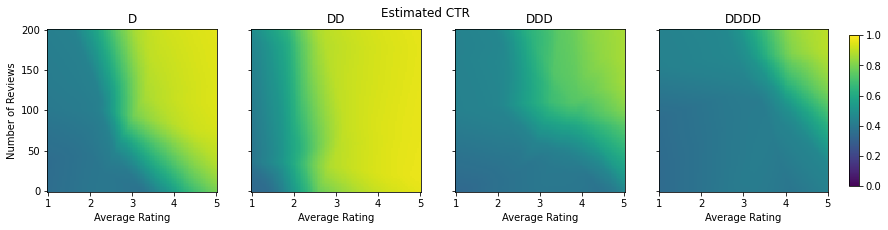

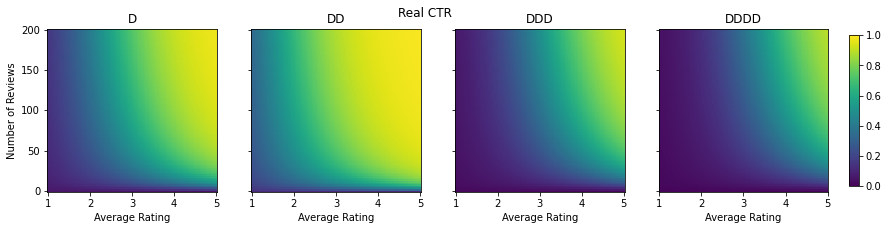

In [14]:
sbr_tanh.evaluation_summary(train=(x_train, y_train), val=(x_val, y_val), test=(x_test, y_test))

# Lattice Model

# Moving Targets

# Conclusions

We can now plot the *CTR* distributions of each model that we tried, which hopefully will show that our method is the best one.

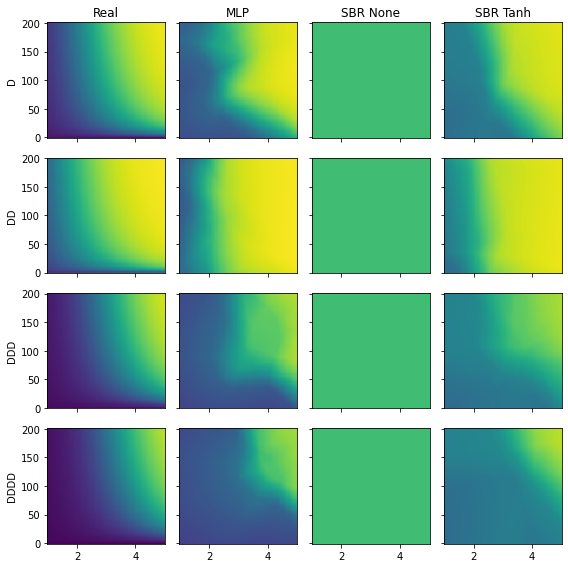

In [15]:
models = {'Real': restaurants, 'MLP': mlp, 'SBR None': sbr_none, 'SBR Tanh': sbr_tanh}
restaurants.plot_conclusions(models=models, figsize=(8, 8))